In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold,  RepeatedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
import h5py
from keras import metrics


In [2]:
data = pd.read_csv("passwords.csv")
data.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


## Pre-processing 


In [3]:
#printing all users
target_names = data.loc[:, 'subject'].unique()
print(target_names)

['s002' 's003' 's004' 's005' 's007' 's008' 's010' 's011' 's012' 's013'
 's015' 's016' 's017' 's018' 's019' 's020' 's021' 's022' 's024' 's025'
 's026' 's027' 's028' 's029' 's030' 's031' 's032' 's033' 's034' 's035'
 's036' 's037' 's038' 's039' 's040' 's041' 's042' 's043' 's044' 's046'
 's047' 's048' 's049' 's050' 's051' 's052' 's053' 's054' 's055' 's056'
 's057' 's058']


In [4]:
cols = data.columns
n_cols = len(cols)-1
n_rows = len(data.index)
print(f"Number of columns = {n_cols}, Number of rows = {n_rows}")


Number of columns = 33, Number of rows = 20800


In [5]:
#Dropping unnecessary data for training
data = data.drop(['sessionIndex', 'rep'], axis=1)

In [6]:
#Applying ON-hot encoding to our users ids (subject)
Tranform_Cols= ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
subjects = data['subject'].nunique()
#transforming the column in the dataset into the new one-hot encoding
data = np.array(Tranform_Cols.fit_transform(data))
#spliting x and y, x takes all features except subject and y takes subject
X = data[:, 52:]
y = data[:,:52]
print(f"X shape = {X.shape}, y shape = {y.shape}")

X shape = (20800, 31), y shape = (20800, 52)


In [7]:
# Split the data into training and testing sets 90% 20% and later we will use a percentage of the training in the validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, shuffle = True, stratify = y)

In [8]:
#Applying standardization
import pickle
Standard_Scaler = StandardScaler()
X_train = Standard_Scaler.fit_transform(X_train)

with open('x.pickle', 'wb') as handle:
    pickle.dump(Standard_Scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
X_test = Standard_Scaler.transform(X_test)

## Training Model

In [9]:
Vanilla_Model = keras.Sequential([
    keras.layers.Dense(1024, input_dim = 31, activation = 'relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='sigmoid'),
    keras.layers.Dense(52, activation='softmax')
])

In [10]:
# Defining an early stop to val loss if it doesn't improve
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [11]:
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
Vanilla_Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
           metrics=['acc', metrics.Precision(), metrics.Recall(), get_f1])

In [13]:
# 15% of the training data will be used in validation
Vanilla_History = Vanilla_Model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.15, callbacks=[callback_early_stopping])

Epoch 1/100
498/498 [==============================] - 9s 15ms/step - loss: 1.6222 - acc: 0.6421 - precision: 0.9674 - recall: 0.3192 - get_f1: 0.4254 - val_loss: 0.7783 - val_acc: 0.8202 - val_precision: 0.9434 - val_recall: 0.6474 - val_get_f1: 0.7644
Epoch 2/100
498/498 [==============================] - 5s 11ms/step - loss: 0.6130 - acc: 0.8524 - precision: 0.9492 - recall: 0.7355 - get_f1: 0.8262 - val_loss: 0.5512 - val_acc: 0.8632 - val_precision: 0.9366 - val_recall: 0.7838 - val_get_f1: 0.8511
Epoch 3/100
498/498 [==============================] - 4s 8ms/step - loss: 0.4299 - acc: 0.8877 - precision: 0.9492 - recall: 0.8243 - get_f1: 0.8812 - val_loss: 0.4352 - val_acc: 0.8828 - val_precision: 0.9423 - val_recall: 0.8319 - val_get_f1: 0.8824
Epoch 4/100
498/498 [==============================] - 5s 11ms/step - loss: 0.3278 - acc: 0.9130 - precision: 0.9558 - recall: 0.8705 - get_f1: 0.9105 - val_loss: 0.3801 - val_acc: 0.8907 - val_precision: 0.9373 - val_recall: 0.8565 - val_

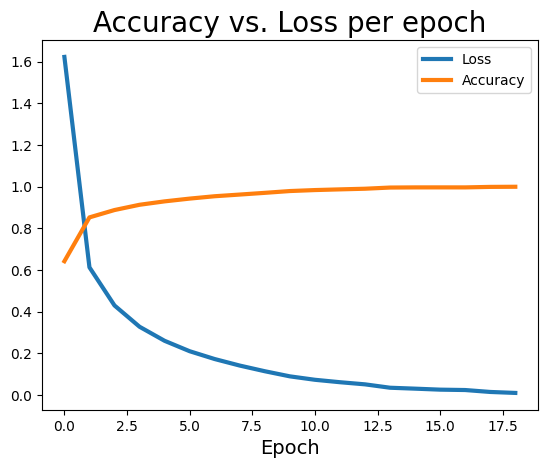

In [14]:
plt.plot( 
    Vanilla_History.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    Vanilla_History.history['acc'], 
    label='Accuracy', lw=3
)
plt.title('Accuracy vs. Loss per epoch', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()

## Evaluation

In [15]:
test_loss, test_acc,precesion, recall,f1 = Vanilla_Model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

65/65 [==============================] - 0s 5ms/step - loss: 0.2093 - acc: 0.9394 - precision: 0.9473 - recall: 0.9332 - get_f1: 0.9402
Test accuracy: 0.9394230842590332


65/65 [==============================] - 0s 4ms/step


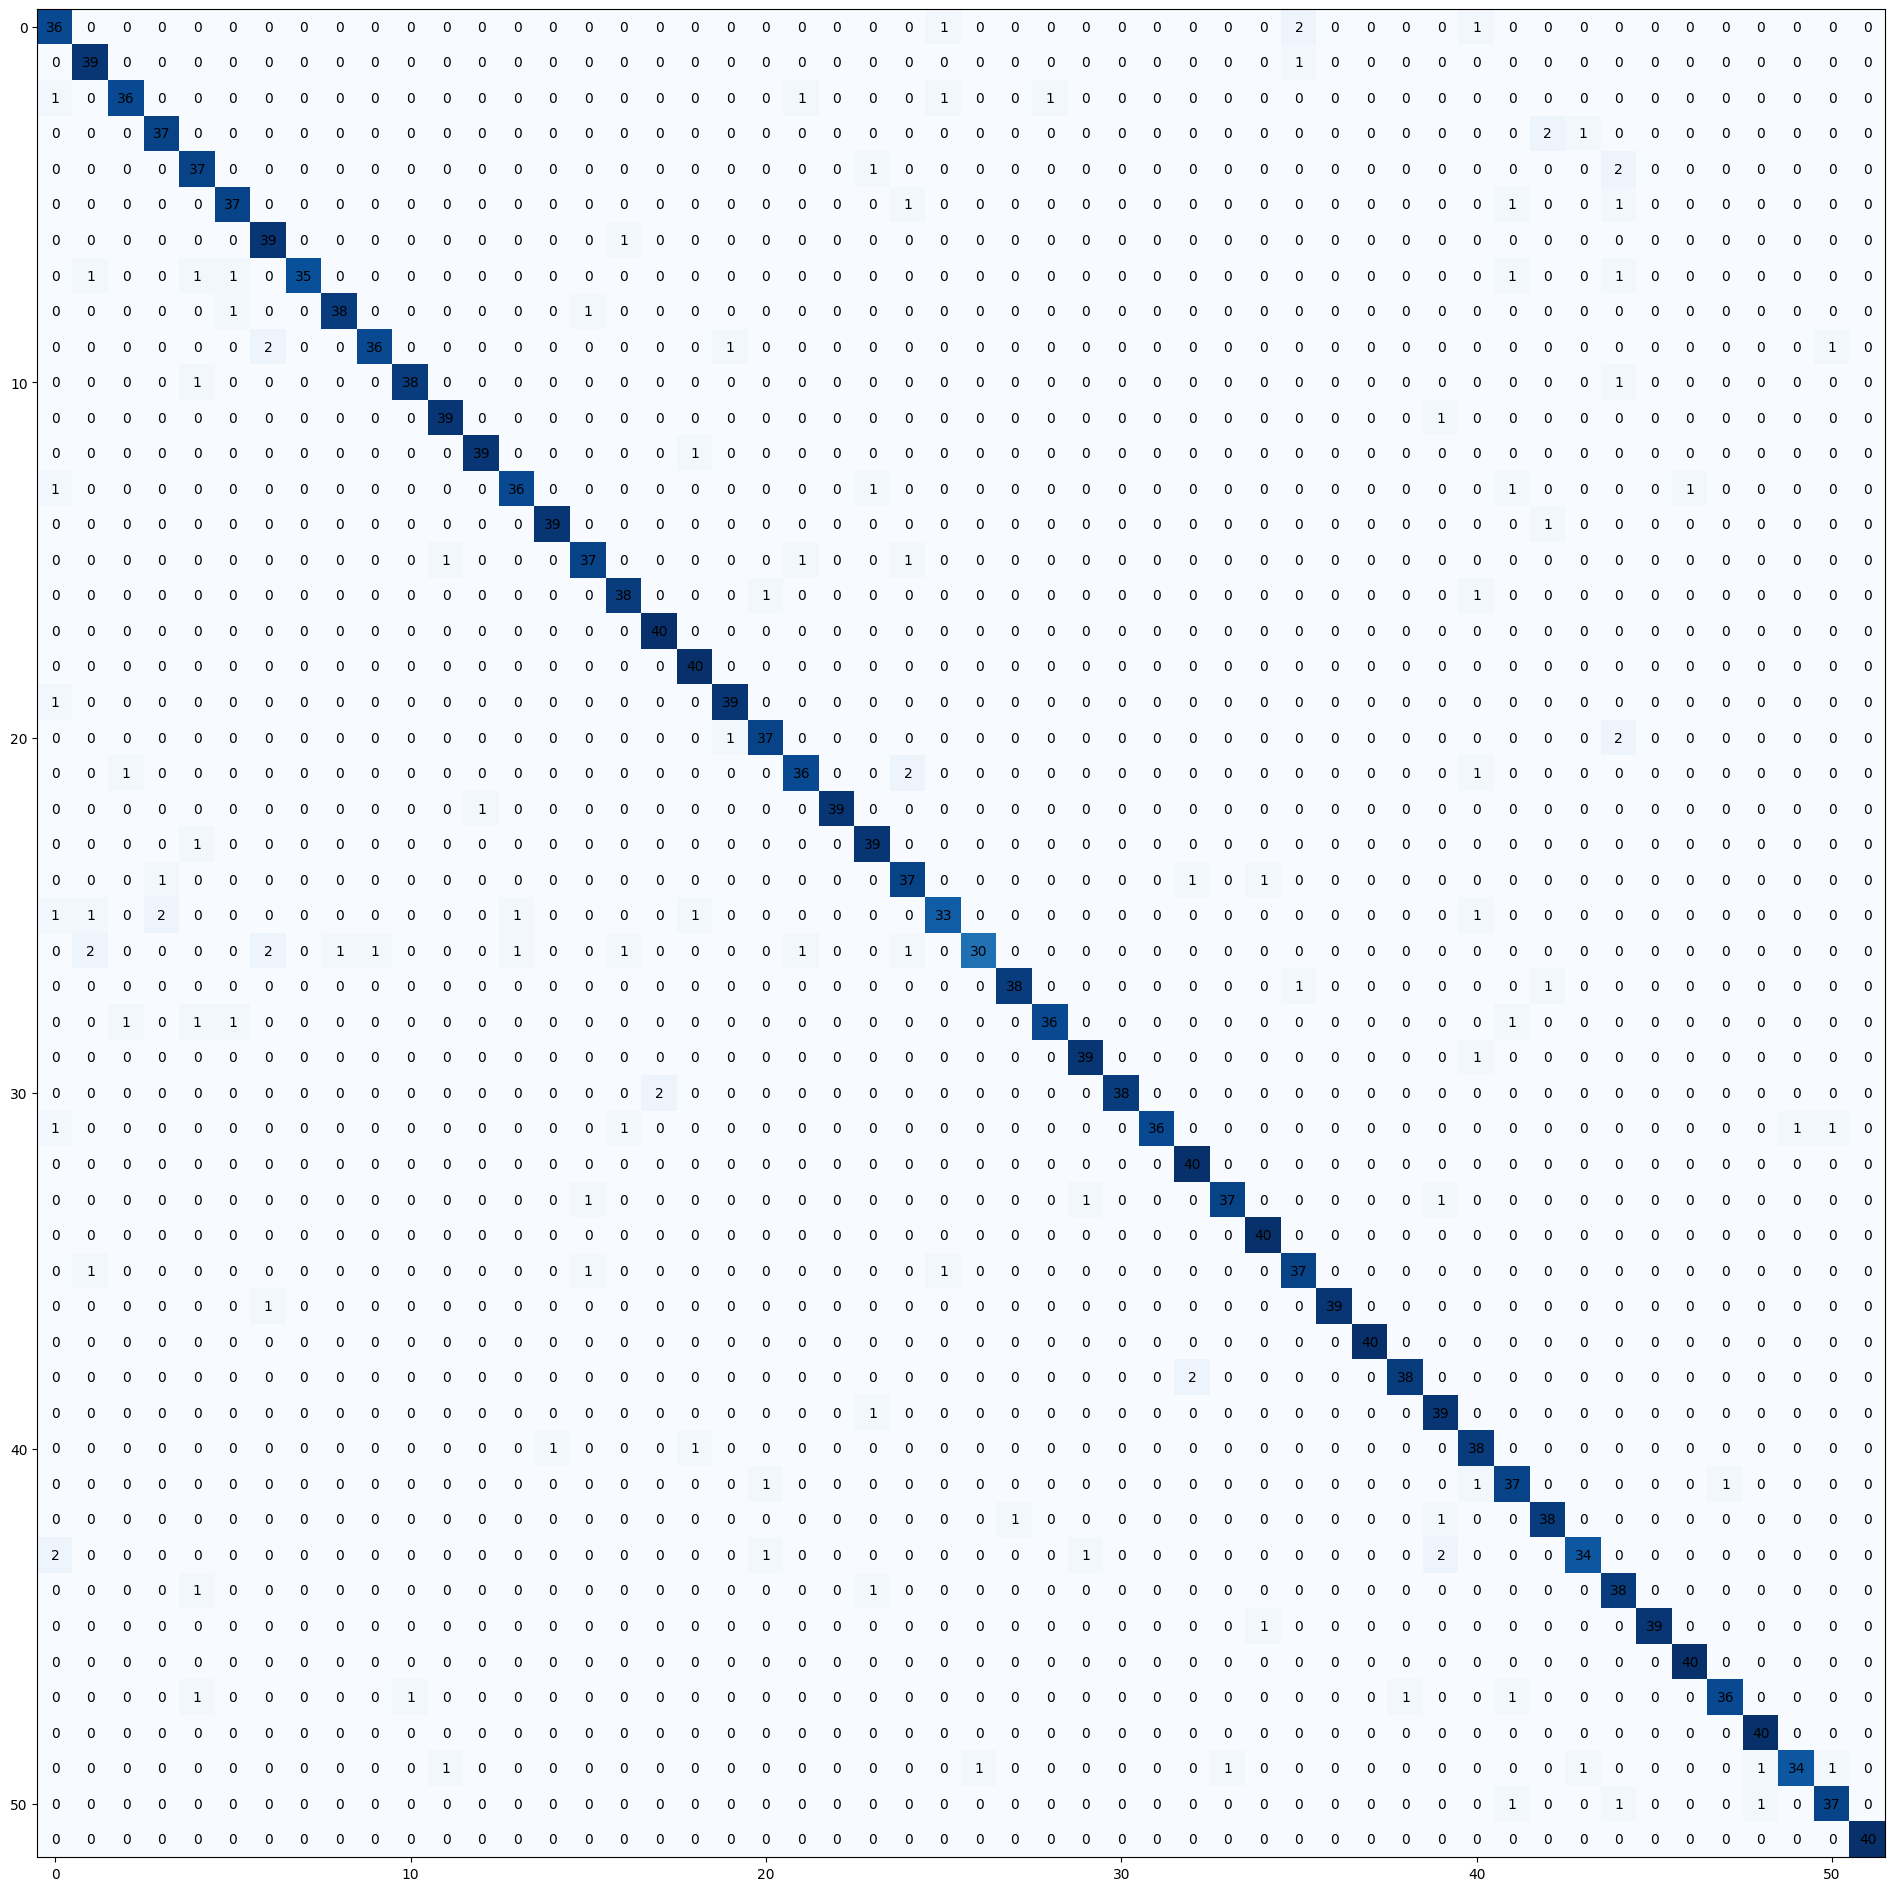

In [16]:
from sklearn.metrics import confusion_matrix
y_pred = Vanilla_Model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(24, 24))

# Plot the confusion matrix as an image
ax.imshow(conf_matrix, cmap=plt.cm.Blues)

# Add text labels to the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, conf_matrix[i, j], ha="center", va="center")

In [17]:
# Saving the model
Vanilla_Model.save('my_model.h5')